# utterance, output 속의 name1과 name2 특성 EDA

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
def make_dataframe(path: str) -> pd.DataFrame:
    """
    Read a json file and return a pandas DataFrame.

    Parameters:
    path (str): Path to the json file.

    Returns:
    pd.DataFrame: DataFrame of the json file.
    """
    # Read the json file
    with open(path, 'r') as file:
        data = json.load(file)

    # Create a DataFrame
    # columns = ['id', 'conversation', 'subject_keyword', 'output']
    df = pd.DataFrame(data)
    df['conversation'] = df['input'].apply(lambda x: x['conversation'])
    df['subject_keyword'] = df['input'].apply(lambda x: x['subject_keyword'])

    # Drop the 'input' column
    df.drop('input', axis=1, inplace=True)

    # Speakers in the conversation
    df['speakers'] = df['conversation'].apply(lambda turns: list(set(turn['speaker'] for turn in turns)))

    # Reorder the columns
    df = df[['id', 'conversation', 'subject_keyword', 'speakers', 'output']]

    return df

In [3]:
# 전처리 데이터 바탕으로 진행
train_df = make_dataframe('preprocessed_train.json')
dev_df = make_dataframe('preprocessed_dev.json')
test_df = make_dataframe('preprocessed_test.json')

In [4]:
train_df.head(1)

,id,conversation,subject_keyword,speakers,output
0,nikluge-2024-일상 대화 요약-train-000001,"[{'speaker': 'SD2000001', 'utterance': '저는 여행 ...",[해외여행],"[SD2000001, SD2000002]",두 화자는 이 대화에서 좋았던 여행지와 기억나는 주요 명소에 대해 이야기했습니다. ...


In [5]:
# result_df = make_dataframe('../results/내가내가.json')
# result2_df = make_dataframe('../results/hyperstella.json')
# result3_df = make_dataframe('../results/hyperstellar2.json')

In [6]:
def name_token_analysis(df: pd.DataFrame, test=None) -> None:
    """
    Analyze the number of tokens in the names of the speakers.

    Parameters:
    df (pd.DataFrame): DataFrame of the json file.
    """

    df = deepcopy(df)

    name_types = [
                ' name ',
                # train
                'name가',
                'name너',
                'name누나가',
                'name는',
                'name님',
                'name님은',
                'name님의',
                'name님이',
                'name도',
                'name라는',
                'name랑',
                'name밖에',
                'name아',
                'name에',
                'name이',
                'name이.',
                'name이가',
                'name이고',
                'name이는',
                'name이도',
                'name이랑',
                'name이랑.',
                'name이랑도',
                'name이한테',
                # dev
                'name에게',
                'name의',] 

    # The number of samples that have 'name' token in the utterance
    have_name_tokens = df['conversation'].apply(lambda turns: any('name' in turn['utterance'] for turn in turns))
    print(f"The number of samples that have 'name' token: {have_name_tokens.sum()}",'/',
          f"{len(df)}")
    
    # Samples that name+int token is in the utterance
    name_int_tokens = df['conversation'].apply(lambda turns: any(re.search(r' name\d+', turn['utterance']) for turn in turns))
    print(f"The number of samples that have 'name+int' token in the utterance : {name_int_tokens.sum()}",'/',
          f"{len(df)}")
    
    # Samples that only name token is in the utterance
    only_name_tokens = df['conversation'].apply(lambda turns: any(any(name_type in turn['utterance'] for name_type in name_types) for turn in turns))
    print(f"The number of samples that have only 'name' token in the utterance : {only_name_tokens.sum()}",'/',
          f"{len(df)}")
    
    #### name과 name+int token이 동시에 있는 경우가 3개 존재!! ####


    # The number of samples that have 'name' token in the output
    if not test:
        have_name_tokens_output = df['output'].apply(lambda x: 'name' in x)
        print(f"The number of samples that have 'name' token in the output: {have_name_tokens_output.sum()}",'/',
            f"{len(df)}")
        
        # print(have_name_tokens_output.index[have_name_tokens_output == True])

        # The number of samples that have 'name' token in the utterance and the output 
        have_name_tokens_both = df.apply(lambda x: any('name' in turn['utterance'] for turn in x['conversation']) and 'name' in x['output'], axis=1)
        print(f"The number of samples that have 'name' token in the utterance and the output: {have_name_tokens_both.sum()}",'/',
            f"{len(df)}")
        
        # print(df[have_name_tokens][have_name_tokens_both == False].index)
        
    print('-'*50)

    # Visualize the correlation between sample's total utterance that have 'name' token in the utterance and the output at the same time and the sample's total utterance length that have 'name' token
    if not test:
        pure_name_tokens = name_int_tokens | only_name_tokens
        pure_df = df[have_name_tokens] # df[pure_name_tokens]

        # total utterance length that have 'name' token
        pure_df['total_utterance_length'] = pure_df['conversation'].apply(lambda turns: sum(len(turn['utterance']) for turn in turns))

        # Samples that have 'name' token in the utterance and the output at the same time
        pure_df['have_name_tokens_both'] = pure_df.apply(lambda x: any('name' in turn['utterance'] for turn in x['conversation']) and 'name' in x['output'], axis=1)
        print(f"The number of samples that have 'name' token in the utterance and the output at the same time: {pure_df['have_name_tokens_both'].sum()}",'/',
            f"{len(pure_df)}")

        # Samples that have 'name' token in the utterance but not in the output
        pure_df['have_name_tokens_not_output'] = pure_df.apply(lambda x: any('name' in turn['utterance'] for turn in x['conversation']) and 'name' not in x['output'], axis=1)
        print(f"The number of samples that have 'name' token in the utterance but not in the output: {pure_df['have_name_tokens_not_output'].sum()}",'/',
            f"{len(pure_df)}")

        # Visualize the correlation between sample's total utterance that have 'name' token in the utterance and the output at the same time and the sample's total utterance length that have 'name' token
        plt.figure(figsize=(10, 5))
        ax = sns.scatterplot(data=pure_df, x='total_utterance_length', y='have_name_tokens_both', hue='have_name_tokens_both')

        # Find min and max and add the text to the plot
        min_length = pure_df[pure_df['have_name_tokens_both']]['total_utterance_length'].min()
        max_length = pure_df[pure_df['have_name_tokens_both']]['total_utterance_length'].max()
        min_index = pure_df[pure_df['have_name_tokens_both']]['total_utterance_length'].idxmin()
        max_index = pure_df[pure_df['have_name_tokens_both']]['total_utterance_length'].idxmax()

        ax.annotate(f"min: {min_length}", (min_length, 1), textcoords="offset points", xytext=(0,-100), arrowprops=dict(facecolor='black', shrink=0.01), color='r')
        ax.annotate(f"max: {max_length}", (max_length, 1), textcoords="offset points", xytext=(0,-100), arrowprops=dict(facecolor='black', shrink=0.01), color='r')

        plt.title("The correlation between sample's total utterance length that have 'name' token and the output at the same time")
        plt.legend()
        plt.show()

The number of samples that have 'name' token: 193 / 506
The number of samples that have 'name+int' token in the utterance : 104 / 506
The number of samples that have only 'name' token in the utterance : 58 / 506
The number of samples that have 'name' token in the output: 13 / 506
The number of samples that have 'name' token in the utterance and the output: 13 / 506
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 13 / 193
The number of samples that have 'name' token in the utterance but not in the output: 180 / 193


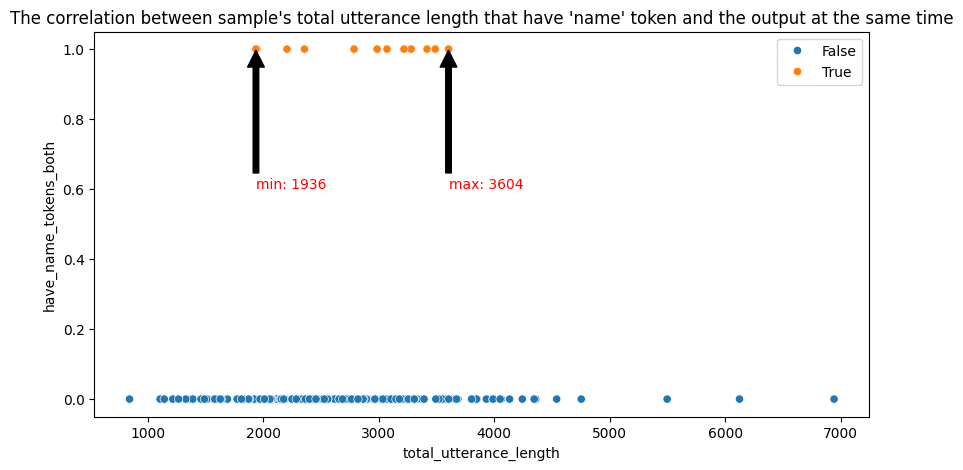

In [7]:
name_token_analysis(train_df)

The number of samples that have 'name' token: 36 / 102
The number of samples that have 'name+int' token in the utterance : 24 / 102
The number of samples that have only 'name' token in the utterance : 9 / 102
The number of samples that have 'name' token in the output: 4 / 102
The number of samples that have 'name' token in the utterance and the output: 4 / 102
--------------------------------------------------
The number of samples that have 'name' token in the utterance and the output at the same time: 4 / 36
The number of samples that have 'name' token in the utterance but not in the output: 32 / 36


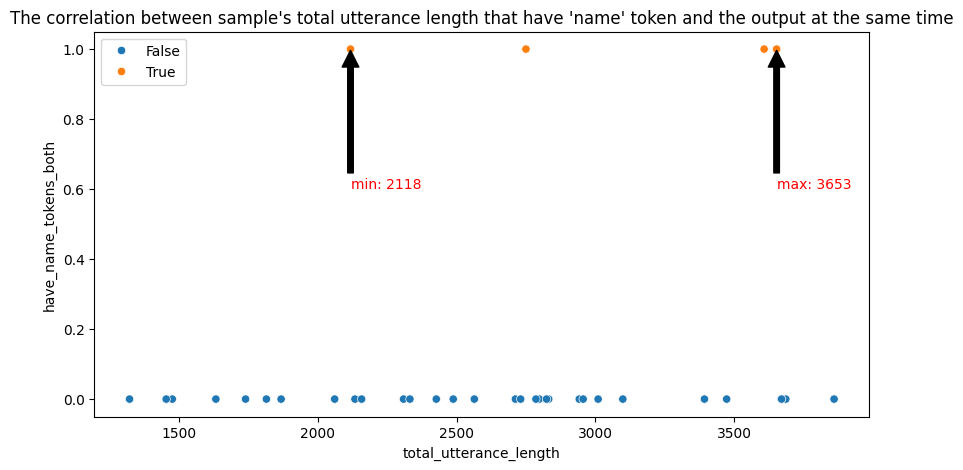

In [8]:
name_token_analysis(dev_df)

In [9]:
name_token_analysis(test_df, test=True)

The number of samples that have 'name' token: 112 / 408
The number of samples that have 'name+int' token in the utterance : 76 / 408
The number of samples that have only 'name' token in the utterance : 23 / 408
--------------------------------------------------


In [ ]:
name_token_analysis(result_df)

In [ ]:
name_token_analysis(result_df)

In [ ]:
name_token_analysis(result2_df)

In [ ]:
name_token_analysis(result3_df)

## 영어 token eda

- 영어로된 토큰은 무엇이 있고 얼마나 존재하는지

    - 무엇이 있는가?

In [80]:
def detect_english_tokens(df: pd.DataFrame) -> None:
    """
    Detect the English tokens in the utterances.

    Parameters:
    df (pd.DataFrame): DataFrame of the json file.
    """

    input_english_tokens = pd.DataFrame(columns=['token', 'utterance'])
    output_english_tokens = pd.DataFrame(columns=['token', 'utterance'])
    input_tokens = []; input_conv = []
    output_tokens = []; output_conv = []
#     input_english_tokens= set()
#     output_english_tokens = set()

    def detect_and_append(conv, for_output=False):
      detect = False
      if for_output:
        if re.findall(r'\S*[A-Za-z]+\S*', conv):
            for en_token in re.findall(r'\S*[A-Za-z]+\S* \S*', conv):
                if not re.match(r'\d*SD\d*', en_token):
                  output_tokens.append(en_token)
                  output_conv.append(conv)
                  detect = True
        return detect
      
      for turn in conv:
            en_tokens = re.findall(r'\S*[A-Za-z]+\S* \S*', turn['utterance'])
            if en_tokens:
                 for en_token in en_tokens:
                    input_tokens.append(en_token)
                    input_conv.append(turn['utterance'])
                 detect = True

      return detect
    
    # The number of samples that have English tokens in the utterance
    have_english_tokens = df['conversation'].apply(detect_and_append)
    print(f"The number of samples that have English tokens: {have_english_tokens.sum()}",'/',
          f"{len(df)}")
    # print("indexes : ",have_english_tokens.index[have_english_tokens == True])
    print('--'*30)
    
    # The number of samples that have English tokens in the output
    have_english_tokens_output = df['output'].apply(lambda x: detect_and_append(x, for_output=True))
    print(f"The number of samples that have English tokens in the output: {have_english_tokens_output.sum()}",'/',
          f"{len(df)}")
    # print("indexes : ",have_english_tokens_output.index[have_english_tokens_output == True])
    print('--'*30)
    
    # The number of samples that have English tokens in the utterance and output at the same time 
    have_english_tokens_both = have_english_tokens & have_english_tokens_output
    print(f"The number of samples that have English tokens in the utterance and output at the same time: {have_english_tokens_both.sum()}",'/',
          f"{len(df)}")
    # print("indexes : ",have_english_tokens_both.index[have_english_tokens_both == True])

    input_english_tokens['token'] = input_tokens
    input_english_tokens['utterance'] = input_conv

    output_english_tokens['token'] = output_tokens
    output_english_tokens['utterance'] = output_conv

    return set(input_tokens), set(output_tokens), input_english_tokens, output_english_tokens

## Train data

### input data

In [31]:
input_tokens, output_tokens, input_df, output_df = detect_english_tokens(train_df)

The number of samples that have English tokens: 195 / 506
------------------------------------------------------------
The number of samples that have English tokens in the output: 34 / 506
------------------------------------------------------------
The number of samples that have English tokens in the utterance and output at the same time: 20 / 506


In [32]:
input_df

,token,utterance
0,name 씨는,그리고 같이 가는 사람에 따라서 숙소 취향이 좀 많이 바뀌는 편인데 name 씨는 ...
1,name 씨는,name 씨는 여행을 할 때 절약하는 스타일인지 아니면 돈을 조금 펑펑 쓰더라도 즐...
2,name 씨는,name 씨는 아주 기억에 남는 일화 같은 게 있나요?
3,name1 씨는,name1 씨는 주로 어떤 음식 좋아하시나요?
4,name1 씨처럼,저도 name1 씨처럼 한식을 가장 좋아해요. 가장 흔하게 접할 수 있고 아무래도 ...
...,...,...
820,company-name6도 있잖아?,거기도 문을 닫지 않았을까 싶은데 내 기억 속에 진짜 맛있는 집들이 다 문을 닫는 ...
821,company-name7 카페,강남 하니까 생각나네 너 예전에 프로필 company-name7 카페 올려 놔서 내...
822,company-name7라고 거기를,근데 company-name7라고 거기를 난 제일 추천해.
823,company-name7 라는,company-name7 라는 술집인 거야? 횟집인 거야?


In [34]:
input_df.groupby('token').count()

,utterance
token,
&address&1에 가면은,1
&address&2 재개발하는,1
company-name 가는,1
company-name 갔을,1
company-name 다닐,4
...,...
others4가 가장,1
others5? 곡이,1
others6가 분위기는,1


In [40]:
input_df.groupby('token').count().sort_values('utterance', ascending=False)

,utterance
token,
name1 씨는,36
name 씨는,30
name2 씨는,23
name2 님은,16
name1 님은,14
...,...
name1가 뭐에,1
name1가 보니까,1
name1가 얼마,1


In [43]:
input_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().head(20)

,token,utterance
0,name1 씨는,36
1,name 씨는,30
2,name2 씨는,23
3,name2 님은,16
4,name1 님은,14
5,name1 씨,10
6,name2 님께서는,9
7,name 씨,9
8,name 씨도,7
9,name1 님께서는,7


In [42]:
input_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().to_csv('eda/train_name_groupby.csv', index=False)

In [63]:
input_df.loc[(input_df['token'] == 'name 씨')]

,token,utterance
74,name 씨,지금 보니까 name 씨 같은 경우는 지금 반도도 그렇고 살아있다도 그렇고 기생충 ...
305,name 씨,name 씨 남편은 아까 무슨 운동을 한다 그랬죠?
306,name 씨,이렇게 동호회나 name 씨 남편처럼 적극적으로 활동하는 타입은 아니고
308,name 씨,나는 아침에 가는 것도 눈치가 보여서 역시 취미 생활은 남편하고 같이 즐기는 게 제...
311,name 씨,딸은 의외로 name 씨 딸처럼 엄마하고 같이하는 거는 별로 시간도 안 맞고 딸은 ...
312,name 씨,그래서 하고 싶은 게 있어요? name 씨 운동은요?
641,name 씨,이번에 name 씨 결혼식 갔다 왔잖아요. 축의금 얼마 냈어요?
642,name 씨,name 씨 name 씨 결혼식 때 왔던 친군 거예요?
643,name 씨,name 씨 name 씨 결혼식 때 왔던 친군 거예요?


### output df

In [61]:
output_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().to_csv('eda/train_output_name_groupby.csv', index=False)

In [62]:
output_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().head(20)

,token,utterance
0,AB형 혈액형을,2
1,AB형에 대한,2
2,3D 업종까지,1
3,company-name5는 소고기,1
4,company-name7이라고 20대,1
5,company-name7라고 거기를,1
6,company-name5이라는 짬뽕,1
7,company-name5에서 가장,1
8,company-name5에 12만,1
9,company-name5를 여러,1


## dev data

In [64]:
input_tokens, output_tokens, input_df, output_df = detect_english_tokens(dev_df)

The number of samples that have English tokens: 36 / 102
------------------------------------------------------------
The number of samples that have English tokens in the output: 8 / 102
------------------------------------------------------------
The number of samples that have English tokens in the utterance and output at the same time: 5 / 102


In [66]:
input_df

,token,utterance
0,name2이는 또,그래서 name2이는 또 천식에 아토피까지 있잖아. 진짜 우리 name2이는 건강을...
1,name2이는 건강을,그래서 name2이는 또 천식에 아토피까지 있잖아. 진짜 우리 name2이는 건강을...
2,name1이 먼저,너는 유산균 아직 안 먹였으면 한번 알아봐가지고 특히 name1이 먼저 먹여. na...
3,name1이가 밥도,너는 유산균 아직 안 먹였으면 한번 알아봐가지고 특히 name1이 먼저 먹여. na...
4,name1이는 고3이잖아.,name1이는 고3이잖아. 그래서 내가 홍삼 제품을 먹였었어. 근데 어느 날 생리통...
...,...,...
167,name10 쌤,그러니깐 그게 너무 청 우리가 청소 시간이 거 5분 10분 완전 짧게 있잖아. 근데...
168,name9 아직도,그러니깐 그게 너무 청 우리가 청소 시간이 거 5분 10분 완전 짧게 있잖아. 근데...
169,name1이 하고,우리 내 친구들 이미 딸 애들이 다들 성인들이어서 친구들 얘기를 들어보면 제일 나이...
170,name1이 하고,우리 내 친구들 이미 딸 애들이 다들 성인들이어서 친구들 얘기를 들어보면 제일 나이...


In [68]:
input_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().head(20)

,token,utterance
0,name1 님은,11
1,name2 님은,7
2,name1 씨는,6
3,name1 를,3
4,name1 님도,2
5,name2 씨는,2
6,name이 언니야,2
7,name1 씨께서,2
8,name1이 하고,2
9,name2 선생님이,2


In [69]:
input_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().to_csv('eda/dev_name_groupby.csv', index=False)

In [71]:
input_df.loc[(input_df['token'] == 'name2 님은')]

,token,utterance
17,name2 님은,그럼 혹시 name2 님은 겨울 말고 다른 계절 도 좋아하는 계절 있으신가요?
19,name2 님은,name2 님은 비가 오면 어떤 기분을 느끼세요?
26,name2 님은,name2 님은 결혼할 때 이혼할 수도 있다 혹시 이런 생각을 가지고 결혼을 하셨나요?
29,name2 님은,혹시 name2 님은 좋아하는 가수나 아니면 아이돌 있으신가요?
147,name2 님은,그럼 name2 님은 문구 브랜드를 차리고 싶다고 하셨잖아요. 근데 문구류에는 되게...
148,name2 님은,그럼 name2 님은 학교에서 이루고 싶은 목표가 있으세요?
151,name2 님은,name2 님은 또 다른 장기 목표가 있을까요?


### output

In [72]:
output_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().to_csv('eda/dev_output_name_groupby.csv', index=False)

In [73]:
output_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().head(20)

,token,utterance
0,"BTS, 빅뱅",1
1,F를 받았지만,1
2,TV 프로그램에,1
3,name1과 시어머니가,1
4,name1과 함께,1
5,name1의 생일에,1
6,name1이 편지를,1
7,name의 여자친구가,1
8,비타민C 등의,1
9,"비타민D와 유산균,",1


## test data

### input

In [82]:
input_tokens, _, input_df, _ = detect_english_tokens(test_df)

The number of samples that have English tokens: 113 / 408
------------------------------------------------------------
The number of samples that have English tokens in the output: 0 / 408
------------------------------------------------------------
The number of samples that have English tokens in the utterance and output at the same time: 0 / 408


In [83]:
input_df

,token,utterance
0,name1 님,name1 님 그럼 제가 여름에 먹는 음식에 대해서 한번 말씀드려볼게요.
1,name1 님은,name1 님은 그럼 여름에 팥빙수 많이 안 드세요?
2,name2 님도,혹시 name2 님도 얼죽아 라는 단어를 아나요?
3,name1 님께서는,예. 저희가 저희끼리 대화를 하면서 뭔가 겨울에 대한 이야길 많이 안 한 것 같은데...
4,name2 님은,name2 님은 크리스마스 좋아하세
...,...,...
464,name3 씨를,한 사람 그러니까 지금 이야기 한 걸 보면 name3 씨를 말한 거 같아요. 털보가...
465,name1 씨한테,특징을 듣고 그때 제가 name1 씨한테 제가 어떻게 이야기를 했냐면 야 본의 아니...
466,name3 씨를,특징을 듣고 그때 제가 name1 씨한테 제가 어떻게 이야기를 했냐면 야 본의 아니...
467,name이 엄마는,name이 엄마는 국내 여행지에서는 어디가 제일 좋았는지


In [90]:
input_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index()

,token,utterance
0,name1 씨는,61
1,name2 님은,43
2,name2 씨는,41
3,name1 님은,35
4,name 씨는,13
...,...,...
184,name1은 약간,1
185,name1은 향수나,1
186,name1이 name1이도,1
187,name1이 네가,1


In [85]:
input_df.groupby('token').count().sort_values('utterance', ascending=False).reset_index().to_csv('eda/test_name_groupby.csv', index=False)

In [89]:
input_df.loc[(input_df['token'] == 'n2 씨도')]

,token,utterance


### name 토큰의 존재 통계

- 'name' 토큰이 존재하는 샘플 수


- 'name' 토큰 유형
    - 유형별 통계


- 'name' 토큰 유형별 전처리

## 온점 뒤에 공백이 존재하지 않는 샘플
- 현재 tokenizer에는 공백이 token으로 사용되고 있다.
    - 뿐만 아니라, 공백이 몇 개가 연속되어 붙어있는지에 따라 서로 다른 token을 사용한다
    - 그러므로, 공백을 어떻게 사용하는지가 문장 생성에 영향을 끼칠 가능성이 있다.